
Processing Model: resnet18
Loading Supervised weights...
Loading Self-Supervised weights from model_saving/fullTraining_resnet18.pth...
Generating comparison plot for resnet18...


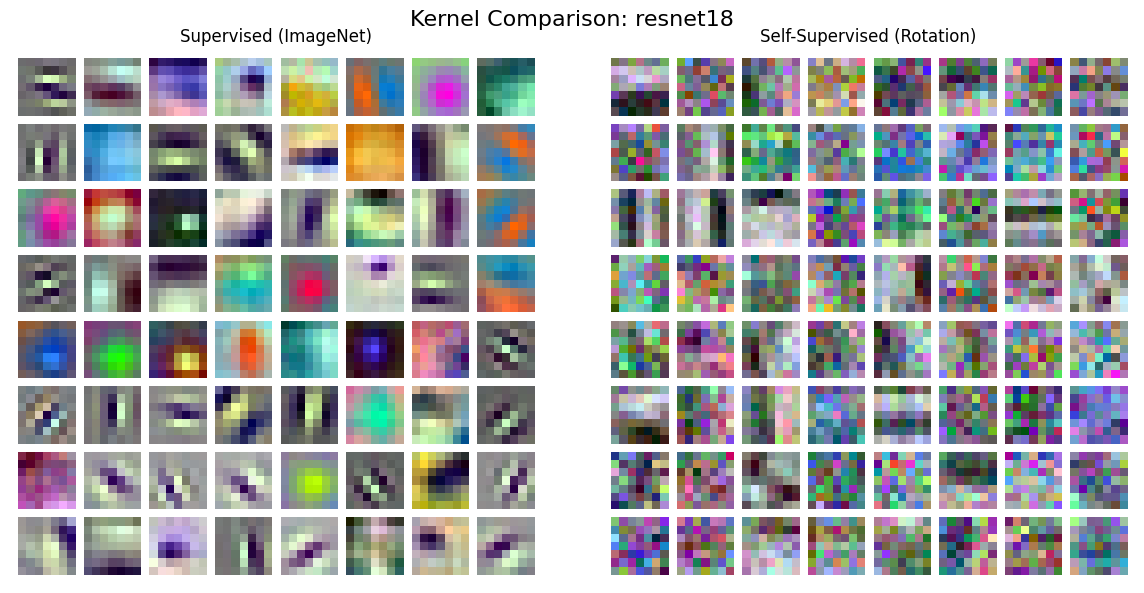


Processing Model: resnet50
Loading Supervised weights...
Loading Self-Supervised weights from model_saving/fullTraining_resnet50.pth...
Generating comparison plot for resnet50...


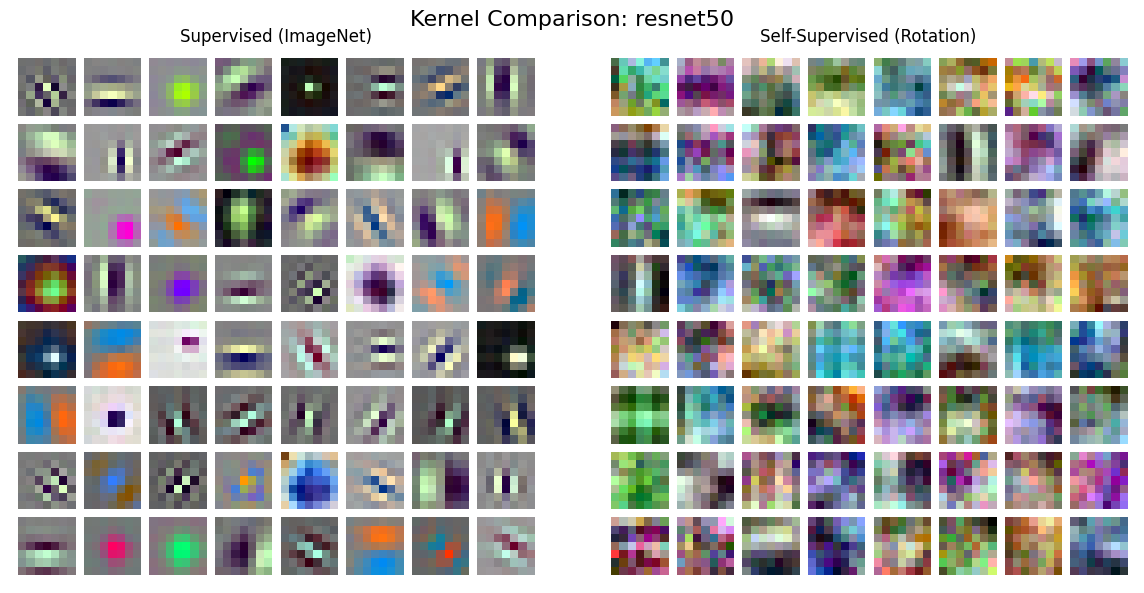


Processing Model: inception_v3
Loading Supervised weights...
Loading Self-Supervised weights from model_saving/fullTraining_inception_v3.pth...
Generating comparison plot for inception_v3...


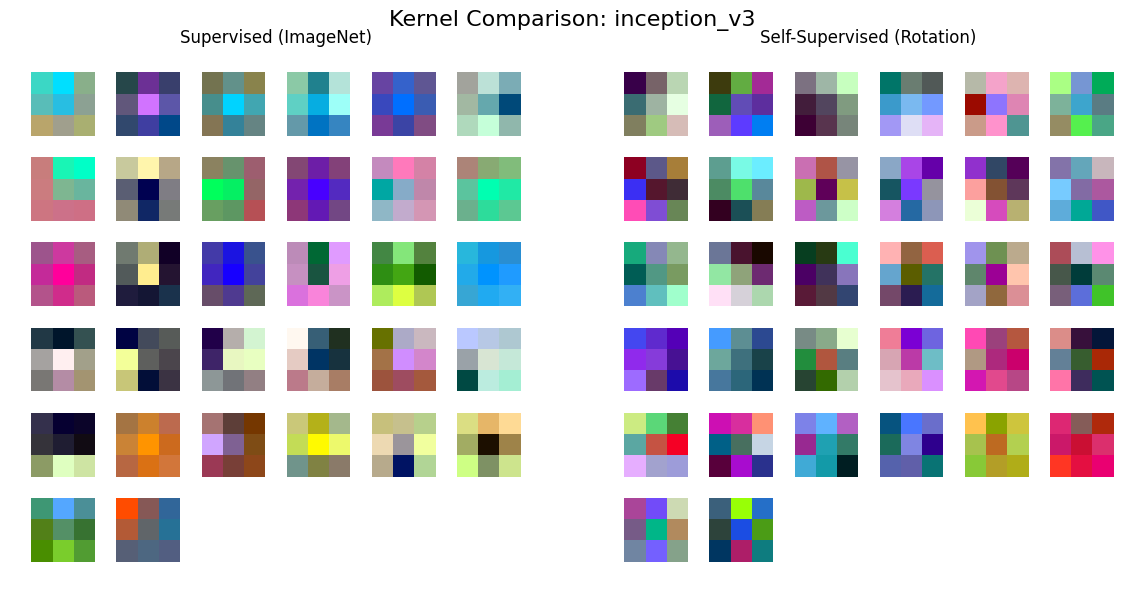


Processing Model: efficientnet_b0
Loading Supervised weights...
Loading Self-Supervised weights from model_saving/fullTraining_efficientnet_b0.pth...
Generating comparison plot for efficientnet_b0...


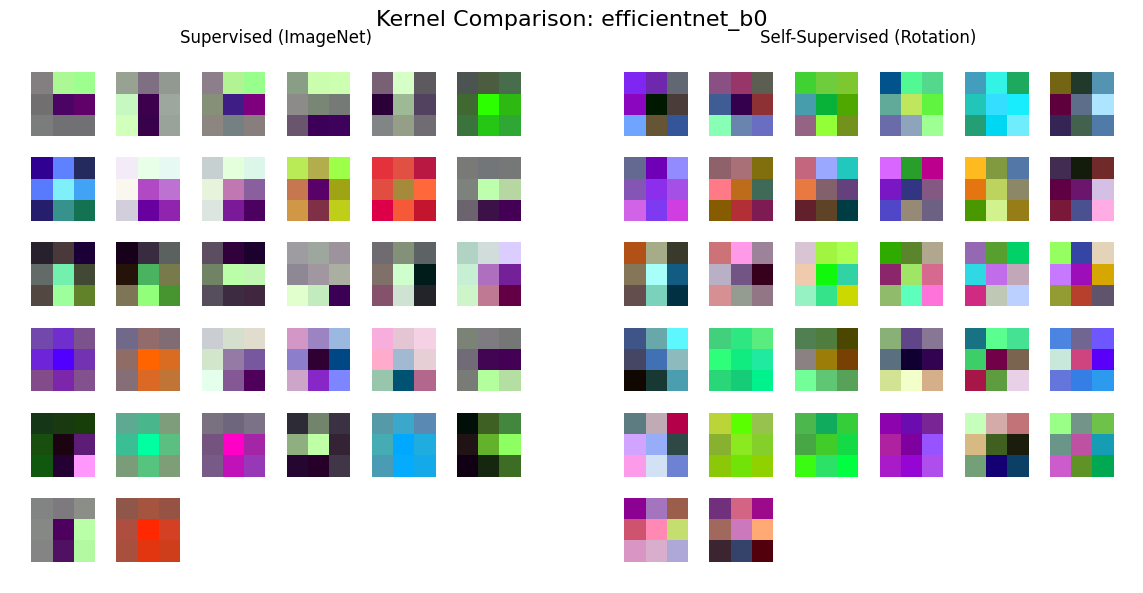


Processing Model: efficientnet_b3
Loading Supervised weights...
Loading Self-Supervised weights from model_saving/fullTraining_efficientnet_b3.pth...
Generating comparison plot for efficientnet_b3...


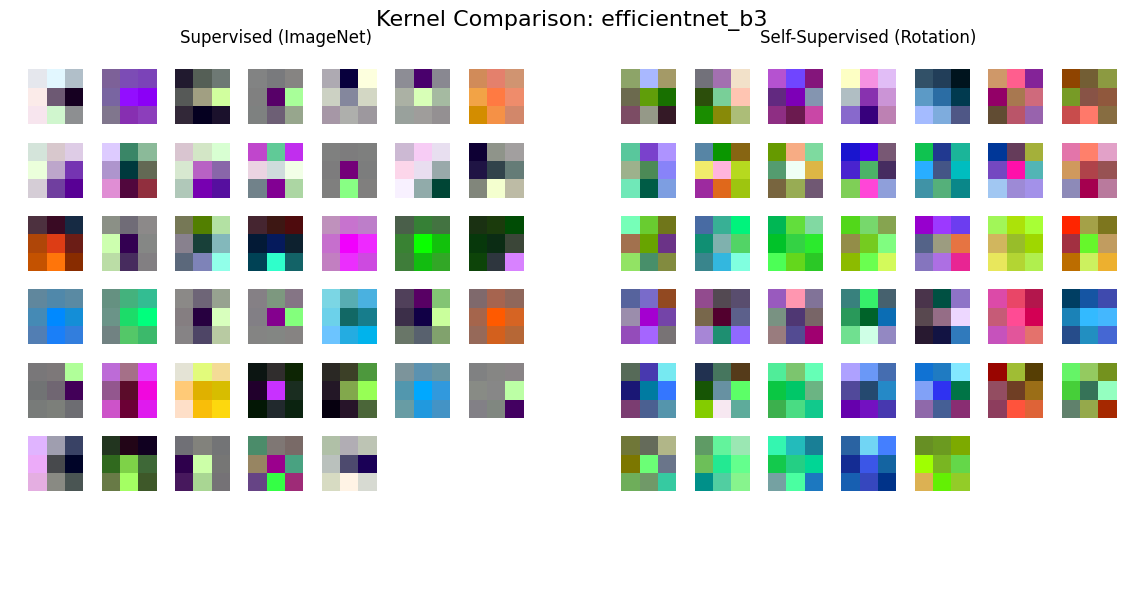

In [11]:
import torch
import torchvision.models as models
import matplotlib.pyplot as plt
import math
import os

# --- 1. CONFIGURATION ---

# Map architecture names to their constructors
architectures = {
    'resnet18': models.resnet18,
    'resnet50': models.resnet50,
    'inception_v3': models.inception_v3,
    'efficientnet_b0': models.efficientnet_b0,
    'efficientnet_b3': models.efficientnet_b3
}

# !!! UPDATE THIS DICTIONARY WITH YOUR REAL PATHS !!!
model_paths = {
    'resnet18': 'model_saving/fullTraining_resnet18.pth',
    'resnet50': 'model_saving/fullTraining_resnet50.pth',
    'inception_v3': 'model_saving/fullTraining_inception_v3.pth',
    'efficientnet_b0': 'model_saving/fullTraining_efficientnet_b0.pth',
    'efficientnet_b3': 'model_saving/fullTraining_efficientnet_b3.pth'
}

# --- 2. HELPER FUNCTIONS ---

def get_first_layer_weights(model, model_name):
    """Extracts first layer weights based on architecture name."""
    try:
        if 'resnet' in model_name:
            return model.conv1.weight.data.cpu()
        elif 'inception' in model_name:
            # Inception v3
            return model.Conv2d_1a_3x3.conv.weight.data.cpu()
        elif 'efficientnet' in model_name:
            # EfficientNet
            return model.features[0][0].weight.data.cpu()
        else:
            print(f"Warning: Logic for {model_name} not found. Skipping.")
            return None
    except AttributeError:
        print(f"Error: Could not find first layer for {model_name}.")
        return None

def normalize_filters(weights):
    """Normalizes weights to 0-1 range for RGB visualization."""
    w = weights.clone()
    # Min-max norm per kernel (N, C, H, W) -> flatten (N, -1)
    min_val = w.view(w.size(0), -1).min(dim=1)[0].view(-1, 1, 1, 1)
    max_val = w.view(w.size(0), -1).max(dim=1)[0].view(-1, 1, 1, 1)
    
    # Avoid division by zero
    diff = max_val - min_val
    diff[diff == 0] = 1e-5
    
    w = (w - min_val) / diff
    return w

def plot_comparison(sup_weights, self_sup_weights, model_name):
    """
    Plots Supervised vs Self-Supervised kernels side-by-side in one figure.
    """
    # Create a figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f"Kernel Comparison: {model_name}", fontsize=16)

    # Helper to draw grid on a specific axis
    def draw_grid_on_axis(weights, ax, title):
        num_kernels = min(weights.shape[0], 64) # Limit to 64
        grid_side = math.ceil(math.sqrt(num_kernels))
        
        # Create a mini-grid image from the weights
        # We manually construct a grid image buffer
        k_h, k_w = weights.shape[2], weights.shape[3]
        padding = 1
        grid_h = grid_side * k_h + (grid_side + 1) * padding
        grid_w = grid_side * k_w + (grid_side + 1) * padding
        
        grid_image = torch.ones(3, grid_h, grid_w) # White background
        
        for idx in range(num_kernels):
            i = idx // grid_side
            j = idx % grid_side
            
            y_start = padding + i * (k_h + padding)
            x_start = padding + j * (k_w + padding)
            
            grid_image[:, y_start:y_start+k_h, x_start:x_start+k_w] = weights[idx]

        # Plot
        ax.imshow(grid_image.permute(1, 2, 0).numpy())
        ax.set_title(title)
        ax.axis('off')

    # Draw both
    draw_grid_on_axis(sup_weights, ax1, "Supervised (ImageNet)")
    draw_grid_on_axis(self_sup_weights, ax2, "Self-Supervised (Rotation)")
    
    plt.tight_layout()
    plt.show()

# --- 3. MAIN LOOP ---

for name, arch_constructor in architectures.items():
    print(f"\n{'='*40}")
    print(f"Processing Model: {name}")
    print(f"{'='*40}")

    path = model_paths.get(name)
    
    # Check if user defined a path for this model
    if not path or not os.path.exists(path):
        print(f"Skipping {name}: Path not found or file missing ({path})")
        continue

    # 1. LOAD SUPERVISED (BASELINE)
    print("Loading Supervised weights...")
    try:
        sup_model = arch_constructor(weights='DEFAULT')
        w_sup = get_first_layer_weights(sup_model, name)
        if w_sup is None: continue
        w_sup_norm = normalize_filters(w_sup)
    except Exception as e:
        print(f"Error loading supervised {name}: {e}")
        continue

    # 2. LOAD SELF-SUPERVISED (CUSTOM)
    print(f"Loading Self-Supervised weights from {path}...")
    try:
        my_model = arch_constructor(weights=None)
        state_dict = torch.load(path, map_location='cpu')

        # A. Clean 'module.' prefix (DataParallel)
        if list(state_dict.keys())[0].startswith('module.'):
            state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}

        # B. Smart Filter: Remove ALL classification heads (fc, classifier, aux_logits)
        # This prevents size mismatches for ANY architecture
        filtered_state_dict = {}
        for k, v in state_dict.items():
            # Skip keys that belong to final classification layers
            if 'fc' in k or 'classifier' in k or 'AuxLogits' in k:
                continue
            filtered_state_dict[k] = v
        
        # C. Load
        my_model.load_state_dict(filtered_state_dict, strict=False)
        
        w_self = get_first_layer_weights(my_model, name)
        if w_self is None: continue
        w_self_norm = normalize_filters(w_self)

    except Exception as e:
        print(f"Error loading custom {name}: {e}")
        continue

    # 3. VISUALIZE
    print(f"Generating comparison plot for {name}...")
    plot_comparison(w_sup_norm, w_self_norm, name)